In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Data preparation

In [3]:
# define custom dataset
class MyDataset(Dataset):
    def __init__(self, feature, target=None, transform=None):

        self.X = feature
        self.Y = target
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform is not None:
            return self.transform(self.X[idx]), self.Y[idx]
        elif self.Y is None:
            return [self.X[idx]]
        return self.X[idx], self.Y[idx]

In [4]:
train_data_dir = "/Users/kavanalipanahi/Downloads/fashion-mnist_train.csv"
test_data_dir = "/Users/kavanalipanahi/Downloads/fashion-mnist_test.csv"

# load data
train = pd.read_csv(train_data_dir)
test = pd.read_csv(test_data_dir)

test_label = test['label']
test.drop(['label'], axis=1, inplace=True)

raw_train_labels = train["label"]
raw_train_imgs = train.drop(labels=["label"], axis=1)

# normalize data
normalized_train = raw_train_imgs / 255.0
normalized_test = test / 255.0

# split data into train and validation
train_split, validation_split, train_labels_split, validation_labels_split = train_test_split(
    normalized_train, raw_train_labels, random_state=0)

# data reshape
test_data = torch.from_numpy(normalized_test.values.reshape((-1, 1, 28, 28)))
train_data = torch.from_numpy(train_split.values.reshape((-1, 1, 28, 28)))
train_labels_data = torch.from_numpy(train_labels_split.values)
validation_data = torch.from_numpy(
    validation_split.values.reshape((-1, 1, 28, 28)))
validation_labels_data = torch.from_numpy(validation_labels_split.values)

# make data loader
train_set = MyDataset(train_data.float(), train_labels_data)
valid_set = MyDataset(validation_data.float(), validation_labels_data)
test_set = MyDataset(test_data.float())
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set,
                                           batch_size=batch_size,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=False)

# Define train function

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(train_set), 'val': len(valid_set)}


def train_model(model,
                criterion,
                optimizer,
                scheduler,
                dataloaders,
                dataset_sizes,
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))
            print(
                f'epoch: {epoch} accuarcy: {epoch_acc:.4f} loss: {epoch_loss:.4f}'
            )

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

# Make model and Training

In [7]:
epochs = 20

# make resnet 18 model
model_ft = models.resnet18(pretrained=False)

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
model_ft.conv1 = nn.Conv2d(1,
                           64,
                           kernel_size=(7, 7),
                           stride=(2, 2),
                           padding=(3, 3),
                           bias=False)

# change fc layer
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# train model
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       dataloaders,
                       dataset_sizes,
                       num_epochs=epochs)

epoch: 0 accuarcy: 0.6631 loss: 0.8953
epoch: 0 accuarcy: 0.8132 loss: 0.4924
epoch: 1 accuarcy: 0.7623 loss: 0.6312
epoch: 1 accuarcy: 0.8104 loss: 0.5234
epoch: 2 accuarcy: 0.7899 loss: 0.5607
epoch: 2 accuarcy: 0.8288 loss: 0.4800
epoch: 3 accuarcy: 0.8125 loss: 0.4970
epoch: 3 accuarcy: 0.8672 loss: 0.3797
epoch: 4 accuarcy: 0.8249 loss: 0.4629
epoch: 4 accuarcy: 0.8684 loss: 0.3629
epoch: 5 accuarcy: 0.8587 loss: 0.3760
epoch: 5 accuarcy: 0.8804 loss: 0.3243
epoch: 6 accuarcy: 0.8701 loss: 0.3419
epoch: 6 accuarcy: 0.8892 loss: 0.3149
epoch: 7 accuarcy: 0.8776 loss: 0.3279
epoch: 7 accuarcy: 0.8912 loss: 0.3164
epoch: 8 accuarcy: 0.8797 loss: 0.3152
epoch: 8 accuarcy: 0.8896 loss: 0.3292
epoch: 9 accuarcy: 0.8835 loss: 0.3044
epoch: 9 accuarcy: 0.8876 loss: 0.3436
epoch: 10 accuarcy: 0.8921 loss: 0.2896
epoch: 10 accuarcy: 0.8872 loss: 0.3369
epoch: 11 accuarcy: 0.8973 loss: 0.2757
epoch: 11 accuarcy: 0.8880 loss: 0.3336
epoch: 12 accuarcy: 0.8955 loss: 0.2815
epoch: 12 accuarcy: 

# Predict

In [8]:
test_pred = torch.LongTensor()

with torch.no_grad():
    for images in test_loader:
        images = torch.autograd.Variable(images[0])
        if torch.cuda.is_available():
            images = images.to(device)

        outputs = model_ft(images)
        predicted = outputs.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, predicted), dim=0)

# evaluatoin

In [12]:
from sklearn.metrics import accuracy_score

In [57]:
from sklearn.metrics import accuracy_score

ts_labs = test_label.to_numpy().reshape(-1, 1)
ts_preds = np.array(test_pred)
print('acc {:.4f}'.format(accuracy_score(ts_labs, ts_preds)))
print('')

confusion_matrix(ts_labs, ts_preds)
print("Classification report for CNN :\n%s\n" %
      (metrics.classification_report(ts_labs, ts_preds)))

acc 0.8835

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      6000
           1       0.98      0.98      0.98      6000
           2       0.81      0.82      0.82      6000
           3       0.89      0.87      0.88      6000
           4       0.78      0.82      0.80      6000
           5       0.96      0.97      0.96      6000
           6       0.70      0.67      0.69      6000
           7       0.94      0.95      0.94      6000
           8       0.97      0.98      0.98      6000
           9       0.96      0.95      0.96      6000

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000




In [59]:
accuracy_score(ts_labs, ts_preds)

0.8834666666666666

In [98]:
report_df_resnet = pd.DataFrame(
    metrics.classification_report(ts_labs, ts_preds,
                                  output_dict=True)).transpose()

In [99]:
output_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

In [100]:
report_df_resnet.index = list(output_mapping.values()) + list(
    report_df.index[10:])

In [102]:
report_df_cnn = pd.read_csv('/Users/kavanalipanahi/Downloads/reponse.csv')

In [104]:
report_df_cnn.index = list(output_mapping.values()) + list(
    report_df_cnn.index[10:])

In [111]:
report_df_cnn = report_df_cnn.head(10)[['f1-score', 'precision', 'recall']]
report_df_resnet = report_df_resnet.head(10)[[
    'f1-score', 'precision', 'recall'
]]

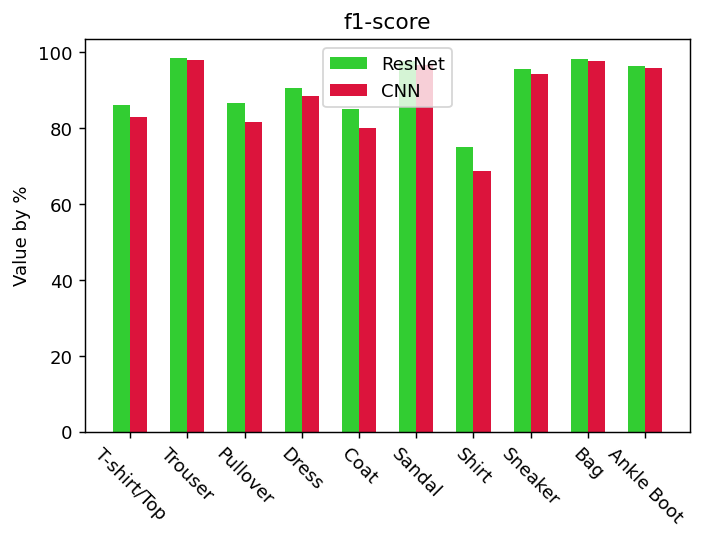

In [187]:
import matplotlib.pyplot as plt
from importlib import reload

plt = reload(plt)

x = np.arange(0, 20, 2)
x_lable = np.array(list(output_mapping.values()))
y1 = report_df_cnn['f1-score']
y2 = report_df_resnet['f1-score']
width = 0.60
plt.figure(figsize=(6, 4), dpi=130)

# plot data in grouped manner of bar type
plt.bar(x - 0.3, y1 * 100, width, color='limegreen', label='ResNet')
plt.bar(x + 0.3, y2 * 100, width, color='crimson', label='CNN')
plt.title('f1-score')
plt.ylabel("Value by %")
plt.xticks(x, x_lable)
plt.xticks(rotation=-45)
plt.legend()

plt.show()

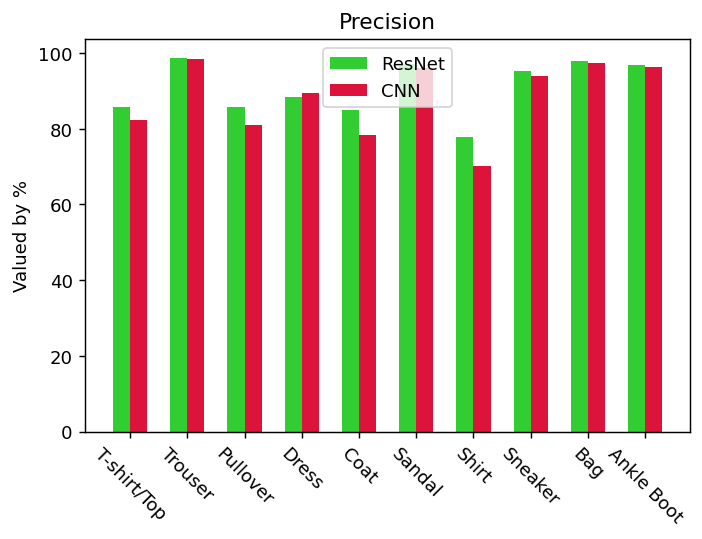

In [190]:
import matplotlib.pyplot as plt
from importlib import reload

plt = reload(plt)

x = np.arange(0, 20, 2)
x_lable = np.array(list(output_mapping.values()))
y1 = report_df_cnn['precision']
y2 = report_df_resnet['precision']
width = 0.60
plt.figure(figsize=(6, 4), dpi=130)

# plot data in grouped manner of bar type
plt.bar(x - 0.3, y1 * 100, width, color='limegreen', label='ResNet')
plt.bar(x + 0.3, y2 * 100, width, color='crimson', label='CNN')
plt.title('Precision')
plt.ylabel("Valued by %")
plt.xticks(x, x_lable)
plt.xticks(rotation=-45)
plt.legend()

plt.show()

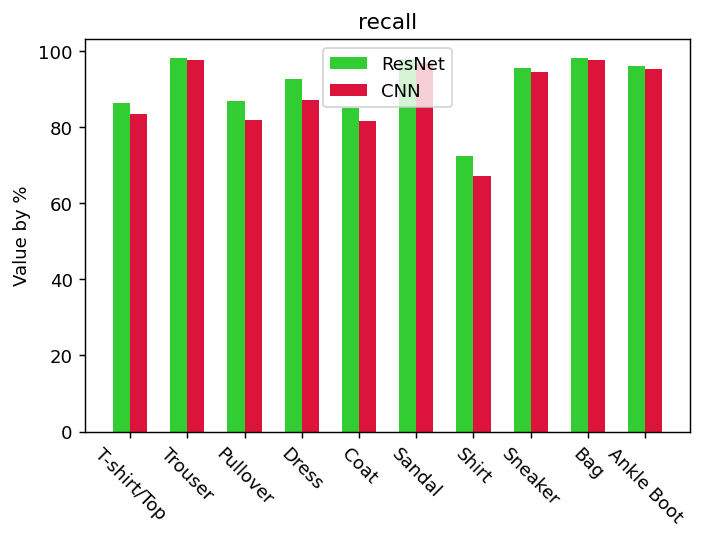

In [188]:
import matplotlib.pyplot as plt
from importlib import reload

plt = reload(plt)

x = np.arange(0, 20, 2)
x_lable = np.array(list(output_mapping.values()))
y1 = report_df_cnn['recall']
y2 = report_df_resnet['recall']
width = 0.60
plt.figure(figsize=(6, 4), dpi=130)

# plot data in grouped manner of bar type
plt.bar(x - 0.3, y1 * 100, width, color='limegreen', label='ResNet')
plt.bar(x + 0.3, y2 * 100, width, color='crimson', label='CNN')
plt.title('recall')
plt.ylabel("Value by %")
plt.xticks(x, x_lable)
plt.xticks(rotation=-45)
plt.legend()

plt.show()